In [ ]:
# Cell A
# dowload data: fragment of the Penn treebank
import nltk
from nltk.corpus import treebank
import nltk.tree.tree as ntree
nltk.download('treebank')

In [2]:
# Cell B
def depth_first_traversal(tree):
    if isinstance(tree, ntree.Tree):
        label='{}'.format(tree.label())
        output = [label]
        for child_traversal, isterminal in [depth_first_traversal(t) for t in tree]:
            if isterminal:
                output.append(child_traversal)
            else:
                output.extend(child_traversal)
        return (output + ['REDUCE'], False)
    else:
        assert isinstance(tree, str)
        return 'SHIFT', True
        
data = [] # items
for fileid in treebank.fileids():
    gold_trees = treebank.parsed_sents(fileid)
    for tree in gold_trees:
        sentence = list(tree.leaves())
        action_sequence, _ = depth_first_traversal(tree)
        num_shifts = len(list(filter(lambda x: x=='SHIFT', action_sequence)))
        assert num_shifts == len(sentence), '{}: {}'.format(fileid, sentence)
        data.append((sentence, action_sequence, tree))

# split train-dev-test
import random
import math
random.seed(0)
data.sort()
random.shuffle(data)
def split(list, fraction):
    index = int(math.ceil(len(list)*fraction))
    return list[:index], list[index:]
#train, dev, test = data[:100], data[100:200], data[200:300]
test, train = split(data, .1) # 10% training data
dev, train = split(train, .1) # 10% of train is for dev
data = {'train': train, 'dev': dev, 'test': test}
action_lengths = sorted([len(x[1]) for x in train])
MAX_STEPS = action_lengths[int(.9*len(action_lengths))]
for split, d in data.items():
    print('{}: {} samples'.format(split, len(d)))
print('max parser steps at inference time: {}'.format(MAX_STEPS))

train: 3169 samples
dev: 353 samples
test: 392 samples
max parser steps at inference time: 189


In [3]:
# Cell C
# shift-reduce parser
class ShiftReduceParser:
    def __init__(self, reduce='REDUCE', shift='SHIFT', no_op='NOOP'):
        self.reduce_kw = reduce
        self.shift_kw = shift
        self.noop_kw = no_op # this is used to do nothing, for padding

    def reset(self):
        self.buffer = []
        self.stack = []

    def initialize_with_sentence(self, sentence):
        assert isinstance(sentence, list)
        self.reset()
        self.buffer = sentence[::-1]
        assert len(self.stack) == 0
    
    def shift(self):
        if len(self.buffer) == 0:
            return
        word = self.buffer.pop()
        self.stack.append((word,True))

    def print_state(self):
        stack_str = 'STACK: {}'.format(self.stack)
        buffer_str = 'BUFFER: {}'.format(self.buffer)
        return '\n'.join([stack_str, buffer_str])

    def reduce(self):
        # pop stack until an uncompleted nonterminal is encountered
        completed_items = []
        head = None
        while True:
            if not self.stack:
                break
            item = self.stack.pop()
            if not item[1]: # item is uncompleted
                head = item # so this will be the head in the reduce operation
                break
            completed_items.append(item)
        # end while True:
        if head is None:
            # put stuff back on the stack! otherwise calling reduce twice could delete items from the stack
            self.stack.extend(completed_items[::-1])
            return
        new_tree = ntree.Tree(head[0], [x[0] for x in completed_items[::-1]])
        self.stack.append((new_tree, True))

    def nonterminal(self, nont):
        # put open non-terminal on stack
        self.stack.append((nont, False))

    def return_parse(self, force=False):
        if not force:
            assert self.done()
            return self.stack[0][0]
        assert force
        # force cast to a tree
        if len(self.stack) == 0:
            candidate_tree = 'S'
        else:
            candidate_tree = self.stack[-1][0]
            candidate_trees = list(filter(lambda x: isinstance(x[0], ntree.Tree), self.stack))
            if len(candidate_trees)>0:
                candidate_tree = sorted(candidate_trees, key=lambda x: x[0].height())[-1][0]
        assert isinstance(candidate_tree, ntree.Tree) or isinstance(candidate_tree, str), candidate_tree
        if not isinstance(candidate_tree, ntree.Tree):
            candidate_tree = ntree.Tree(candidate_tree, [])
        return candidate_tree

    def step(self, action):
        if action == self.reduce_kw:
            self.reduce()
        elif action == self.shift_kw:
            self.shift()
        elif action == self.noop_kw:
            pass
        else:
            self.nonterminal(action)
            
    def done(self):
        buffer_empty = len(self.buffer) == 0
        single_item = (len(self.stack) == 1)
        completed = False
        if single_item:
            completed = self.stack[0][1]
        return buffer_empty and single_item and completed

In [4]:
# Cell D
# check validity of parser
test_parser = ShiftReduceParser()
for split, d in data.items():
    for sentence, actions, tree in d:
        test_parser = ShiftReduceParser()
        test_parser.initialize_with_sentence(sentence)
        for action in actions:
            test_parser.step(action)
        assert test_parser.done()
        assert test_parser.return_parse() == tree

In [5]:
# Cell E
# trainer class
# Q1: What do the "dependency" metrics measure?
# Q1: You do not need to explain what precision, recall and F1 are,
# Q1: but you do need to explain what sets they are computed against.

import itertools
from tqdm import tqdm

class Metrics:
    def __init__(self):
        self.exact_match = None
        self.edit_distance = None
        self.precision = None
        self.recall = None
        self.f1 = None

    def reset(self):
        self.exact_match = []
        self.edit_distance = []
        self.subtree_precision = []
        self.subtree_recall = []
        self.subtree_f1 = []
        self.dependency_precision = []
        self.dependency_recall = []
        self.dependency_f1 = []

    def overlap(self, forest1, forest2):
        counter = 0
        # candidate in forest1 can only match once
        for t1 in forest1:
            for t2 in forest2:
                if t1==t2:
                    counter += 1
                    break
        return counter
        
    def levenshtein_distance(self, a, b):
        output = {}
        assert isinstance(a, list)
        assert isinstance(b, list)
        for ii in range(1+len(a)):
            output[(ii,0)] = ii
            for jj in range(1+len(b)):
                output[(0, jj)] = jj
                if ii and jj:
                    output[(ii,jj)] = min(
                        output[(ii-1,jj)] + 1,
                        output[(ii, jj-1)] + 1,
                        output[(ii-1, jj-1)] + int(a[ii-1]!=b[jj-1]))
        return output[(len(a),len(b))]
    
    def record_sequences(self, predictions, gold_sequences):
        assert len(predictions) == len(gold_sequences)
        def is_list_of_list_of_str(x):
            output = isinstance(x, list)
            for y in x:
                output &= isinstance(y, list)
                for z in y:
                    output &= isinstance(z, str)
            return output
        assert is_list_of_list_of_str(gold_sequences), gold_sequences
        assert is_list_of_list_of_str(predictions), predictions
        for p, g in zip(predictions, gold_sequences):
            self.edit_distance.append(self.levenshtein_distance(p,g)/len(g)) 

    def all_links(self, tree):
        assert isinstance(tree, str) or isinstance(tree, ntree.Tree)
        if isinstance(tree, str):
            return []
        elif len(tree) == 0:
            return []
        else:
            output = [(tree.label(), child if isinstance(child, str) else child.label()) for child in tree]
            for child in tree:
                output.extend(self.all_links(child))
            return output
    
    def record_trees(self, predictions, gold_references):
        assert len(predictions) == len(gold_references)
        assert all(isinstance(g, ntree.Tree) for g in gold_references)
        assert all(isinstance(p, ntree.Tree) for p in predictions), predictions
        for p, g in zip(predictions, gold_references):
            self.exact_match.append(int(p==g))
            # dependencies
            ps = self.all_links(p)
            gs = self.all_links(g)
            assert gs
            ncp = self.overlap(ps, gs) # number correct precision
            ncr = self.overlap(gs, ps) # number correct recall
            lps = max(1,len(ps))
            lgs = max(1,len(gs))
            self.dependency_precision.append(ncp/lps)
            self.dependency_recall.append(ncr/lgs)
            f1 = 0
            if ncr or ncp:
                f1 = 2*ncp*ncr/(lps*ncr + lgs*ncp)
            self.dependency_f1.append(f1)
            # subtrees
            ps = list(p.subtrees())
            gs = list(g.subtrees())
            assert ps
            assert gs
            ncp = self.overlap(ps, gs) # number correct precision
            ncr = self.overlap(gs, ps) # number correct recall
            lps = max(1,len(ps))
            lgs = max(1,len(gs))
            self.subtree_precision.append(ncp/lps)
            self.subtree_recall.append(ncr/lgs)
            f1 = 0
            if ncr or ncp:
                f1 = 2*ncp*ncr/(lps*ncr + lgs*ncp)
            self.subtree_f1.append(f1)

    def get_metrics(self):
        def mean(l):
            return sum(l)/len(l)
        output = {'exact match': mean(self.exact_match),
                  'dependency precision': mean(self.dependency_precision),
                  'dependency recall': mean(self.dependency_recall),
                  'dependency f1': mean(self.dependency_f1),
                  'subtree precision': mean(self.subtree_precision),
                  'subtree recall': mean(self.subtree_recall),
                  'subtree f1': mean(self.subtree_f1),
                  'edit distance': mean(self.edit_distance),
                  'N': {
                      'exact match': len(self.exact_match),
                      'dependency precision': len(self.dependency_precision),
                      'dependency recall': len(self.dependency_recall),
                      'dependency f1': len(self.dependency_f1),
                      'subtree precision': len(self.subtree_precision),
                      'subtree recall': len(self.subtree_recall),
                      'subtree f1': len(self.subtree_f1),
                      'edit distance': len(self.edit_distance),
                      }
                  }
        return output

In [6]:
# Cell F
# BM25 retriever
# Q2: What is BM25? How does this retriever work?
from rank_bm25 import BM25Okapi
class FewShotRetriever:
    def __init__(self, data_set):
        # data_set contains items from the training set
        assert isinstance(data_set, list)
        assert all(isinstance(x, tuple) for x in data_set)
        self.data = [(x[0], x[1]) for x in data_set]
        self.bm25 = None
    def build_index(self):
        self.corpus = [x[0] for x in self.data]
        self.bm25 = BM25Okapi(self.corpus)
    def get_samples(self, query, n=4):
        tokenized_query = query.split(" ")
        top_n = self.bm25.get_top_n(tokenized_query, self.data, n=n)
        return top_n

# build retriever on training data
retriever = FewShotRetriever(data['train'])
retriever.build_index()

In [7]:
# Cell G
import numpy as np
import scipy.stats as sh
def valid_estimate(records):
    assert isinstance(records, list)
    assert len(records)>0
    assert all(isinstance(x, float) for x in records)
    mu = np.mean(records)
    interval = sh.t.interval(confidence=.9, df=len(records)-1, loc=mu, scale=sh.sem(records))
    criterion = (interval[1]-interval[0]) < .1
    return criterion

In [8]:
# Cell H
# LLM parser
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
import json
class LLMParser:
    def __init__(self, model_name, retriever, n_few_shot=2, max_tokens=100):
        assert isinstance(retriever, FewShotRetriever)
        self.retriever=retriever
        assert isinstance(max_tokens, int)
        self.max_tokens = max_tokens
        assert isinstance(model_name, str)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForCausalLM.from_pretrained(model_name, pad_token_id=self.tokenizer.eos_token_id)
        assert isinstance(n_few_shot, int)
        self.n_few_shot=n_few_shot

    def generate(self, input_strings):
        assert isinstance(input_strings, list)
        assert len(input_strings)>0
        assert all(isinstance(ii, str) for ii in input_strings)
        prompts = self.make_prompts(input_strings)
        pipe = pipeline(
            "text-generation", 
            model=self.model,
            tokenizer=self.tokenizer
        )
        generation_args = {
            "max_new_tokens": self.max_tokens,
            "return_full_text": False,
            "do_sample": False,
            "stop_strings": ['\n'],
            "tokenizer": self.tokenizer,
            "pad_token_id": self.tokenizer.eos_token_id

        }
        output = pipe(prompts, **generation_args)
        output = [oo[0] for oo in output]
        assert len(output) == len(prompts)
        output = [{'prompt': prompt, 'lm_output': x['generated_text']} for x, prompt in zip(output, prompts)]
        return output
    
    def make_prompt(self, input_string):
        samples = self.retriever.get_samples(input_string, n=self.n_few_shot)
        #assert len(samples) == self.n_few_shot
        prompt = ["{}\n{}".format(" ".join(x), " ".join(y)) for x, y in samples]
        prompt.append("{}\n".format(input_string))
        prompt = '\n'.join(prompt)
        return prompt
        
    def make_prompts(self, input_strings):
        prompts = [self.make_prompt(input_string) for input_string in input_strings]
        return prompts

    def eval(self, data, batch_size=16, variable_size=False):
        if variable_size:
            return self.eval_variable_size(data, batch_size=batch_size)
        metrics = Metrics()
        metrics.reset()
        for position in tqdm(range(0,len(data),batch_size)):
            chunk = data[position:position+batch_size]
            assert len(chunk)>0
            # chunk is a list of tuples (input_seq, action_seq, tree)
            self.eval_step(chunk, metrics)
        return metrics.get_metrics()

    def eval_variable_size(self, data, batch_size=16):
        metrics = Metrics()
        metrics.reset()
        position=0
        terminate=False
        while (position<len(data)) and (not terminate):
            chunk = data[position:position+batch_size]
            assert len(chunk)>0
            # chunk is a list of tuples (input_seq, action_seq, tree)
            self.eval_step(chunk, metrics)
            position+=batch_size
            terminate = valid_estimate(metrics.edit_distance)
        return metrics.get_metrics()

    def eval_step(self, chunk, metrics):
        # chunk is a list of tuples (input_seq, action_seq, tree)
        sentences = [" ".join(x[0]) for x in chunk] # this is a very basic form of detokenization
        y = self.generate(sentences)
        generated_sequences = [x['lm_output'].split() for x in y]
        metrics.record_sequences(generated_sequences, [x[1] for x in chunk])
        trees = []
        for ii,sentence in enumerate(sentences):
            parser=ShiftReduceParser()
            parser.initialize_with_sentence(sentence.split())
            for action in generated_sequences[ii]:
                parser.step(action)
            trees.append(parser.return_parse(force=True))
        assert len(trees) == len(chunk)
        metrics.record_trees(trees, [x[2] for x in chunk])

In [ ]:
# Cell I
from torch.profiler import profile, record_function, ProfilerActivity
import json

#TODO : Compute 90% interval

def compute_flops(model, input_ids):
    with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
        with record_function("model_inference"):
            model(input_ids)
    flops = sum([event.cpu_time_total for event in prof.key_averages()])
    return flops

def evaluate_model(model_name, retriever, data, results):
    llm_parser = LLMParser(model_name, retriever)
    model_key = model_name.split('/')[-1]
    results[model_key] = {}

    print(f"\n\n########## {model_name} ##########")

    for n_few_shot in tqdm([0, 1, 2, 4, 8, 16]):
        #print('=== {} ==='.format(n_few_shot))
        llm_parser.n_few_shot = n_few_shot
        metrics = llm_parser.eval(data['dev'], variable_size=True)
        #print(json.dumps(metrics, indent=2))

        # Compute FLOPs for a sample input
        sample_input = data['dev'][0][0]  # Take the first sample from the dev set
        input_ids = llm_parser.tokenizer(" ".join(sample_input), return_tensors="pt").input_ids
        flops = compute_flops(llm_parser.model, input_ids)
        #print(f"FLOPs for {n_few_shot} few-shot examples: {flops}")

        # Store the results
        results[model_key][n_few_shot] = {
            "metrics": metrics,
            "flops": flops,
        }


results = {}

evaluate_model("HuggingFaceTB/SmolLM-135M", retriever, data, results)
evaluate_model("distilgpt2", retriever, data, results)
evaluate_model("EleutherAI/gpt-neo-125M", retriever, data, results)

# Save results to a file
with open('results.txt', 'w') as f:
    json.dump(results, f, indent=2)

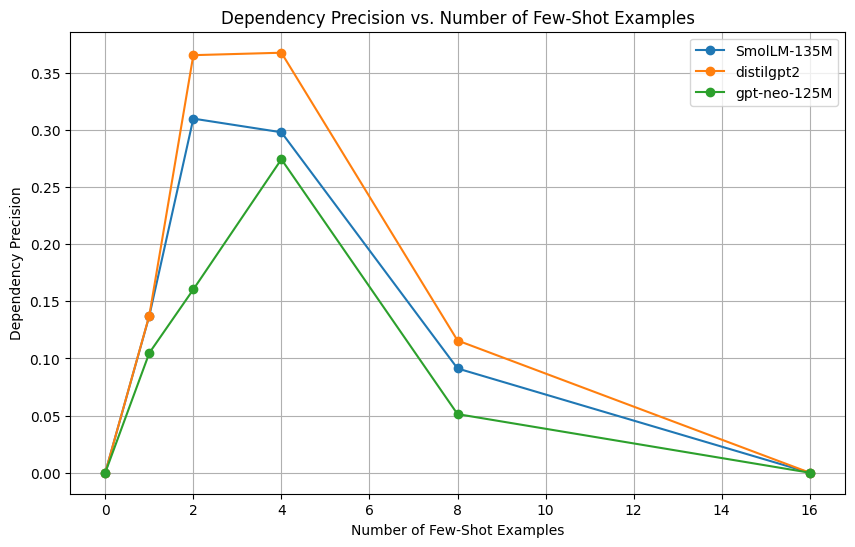

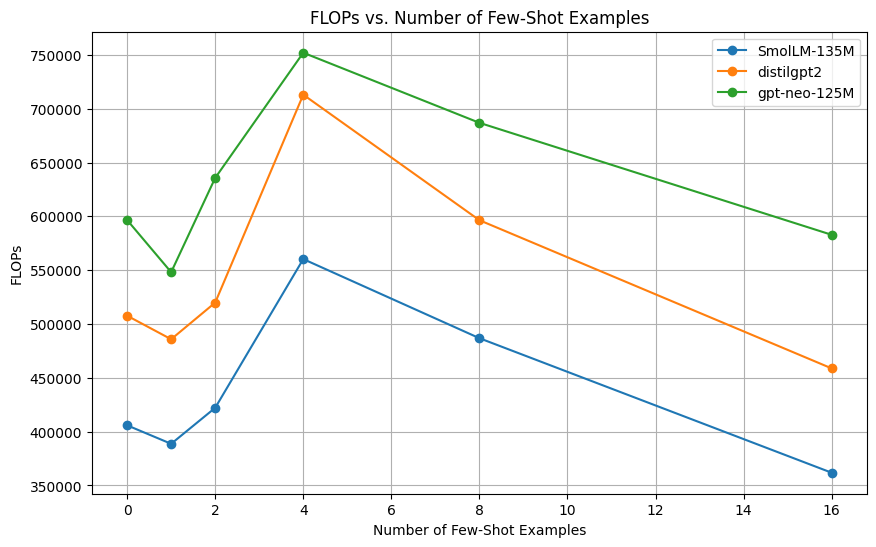

In [39]:
import matplotlib.pyplot as plt

# Load the results from the JSON files
with open('results.txt', 'r') as f:
    results = json.load(f)
    smollm_results = results["SmolLM-135M"]
    distilgpt2_results = results["distilgpt2"]
    gpt_neo_results = results["gpt-neo-125M"]

# Function to extract data for plotting
def extract_data(results, metric):
    x = []
    y = []
    for n_few_shot, data in results.items():
        x.append(int(n_few_shot))
        y.append(data['metrics'][metric])
    return x, y

# Plot precision vs. number of few-shot examples
plt.figure(figsize=(10, 6))
for model_name, results in [("SmolLM-135M", smollm_results),("distilgpt2", distilgpt2_results),("gpt-neo-125M", gpt_neo_results)]:
    x, y = extract_data(results, 'dependency precision')
    plt.plot(x, y, label=model_name, marker='o')

plt.xlabel('Number of Few-Shot Examples')
plt.ylabel('Dependency Precision')
plt.title('Dependency Precision vs. Number of Few-Shot Examples')
plt.legend()
plt.grid(True)
plt.show()

# Plot FLOPs vs. number of few-shot examples
plt.figure(figsize=(10, 6))
for model_name, results in [("SmolLM-135M", smollm_results), ("distilgpt2", distilgpt2_results), ("gpt-neo-125M", gpt_neo_results)]:
    x = []
    y = []
    for n_few_shot, data in results.items():
        x.append(int(n_few_shot))
        y.append(data['flops'])
    plt.plot(x, y, label=model_name, marker='o')

plt.xlabel('Number of Few-Shot Examples')
plt.ylabel('FLOPs')
plt.title('FLOPs vs. Number of Few-Shot Examples')
plt.legend()
plt.grid(True)
plt.show()